# การจำแนกเสียง (Audio)

# หัวข้อที่สนใจ : ถ่ายทอดการเรียนรู้ด้วย YAMNet เพื่อการจำแนกเสียงสิ่งแวดล้อม

        YAMNet เป็นโครงข่ายประสาทเทียมที่ผ่านการฝึกอบรมมาแล้ว ซึ่งใช้สถาปัตยกรรมการบิดแบบแยกส่วนเชิงลึกของ MobileNetV1 
สามารถใช้รูปคลื่นเสียงเป็นอินพุต และทำการคาดการณ์อย่างอิสระสำหรับรายการเสียง 521 รายการจากคลังข้อมูล AudioSet
        ภายในโมเดลจะแยก "เฟรม" ออกจากสัญญาณเสียงและประมวลผลแบทช์ของเฟรมเหล่านี้ โมเดลเวอร์ชันนี้ใช้เฟรมที่มีความยาว 0.96 วินาที และแยกหนึ่งเฟรม
ทุกๆ 0.48 วินาที

In [53]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from IPython import display

In [54]:
# เลือกโมเดล YAMNet มาใช้  คัดลอก URL และใช้ฟังก์ชั่น load 

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [55]:
# โหลดไฟล์ตัวอย่างมาใช้  (WAV เป็นไฟล์เสียง)

testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')
print(testing_wav_file_name)

./test_data\miaow_16k.wav


In [56]:
# ฟังก์ชั่นยูทิลิตี้สำหรับการโหลดไฟล์เสียง และตรวจสอบให้แน่ใจว่าอัตราตัวอย่างถูกต้อง

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

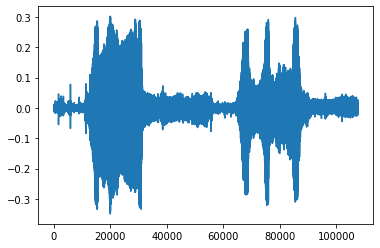

In [57]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# เล่นไฟล์เสียง
display.Audio(testing_wav_data, rate=16000)

In [58]:
# ทำการโหลดคลาสแมป

class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [59]:
# เรียกใช้งานฟังก์ชั่น

scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is : {inferred_class}')
print(f'The embeddings shape : {embeddings.shape}')

The main sound is : Animal
The embeddings shape : (13, 1024)


In [60]:
# ชุดข้อมูล ESC-50 เป็นคอลเลกชั่นการบันทึกเสียงสิ่งแวดล้อมความยาว 5 วินาที 2,000 รายการ ชุดข้อมูลประกอบด้วย 50 คลาส โดยมี 40 ตัวอย่างต่อคลาส
# ดาวน์โหลดชุดข้อมูลและแตกไฟล์

_ = tf.keras.utils.get_file('ESC-50-master.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [61]:
# ทำการสำรวจข้อมูล

esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [62]:
# กรองข้อมูล

my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A
175,./datasets/ESC-50-master/audio/1-34094-A-5.wav,1,1,cat,False,34094,A
176,./datasets/ESC-50-master/audio/1-34094-B-5.wav,1,1,cat,False,34094,B
229,./datasets/ESC-50-master/audio/1-47819-A-5.wav,1,1,cat,False,47819,A
230,./datasets/ESC-50-master/audio/1-47819-B-5.wav,1,1,cat,False,47819,B
231,./datasets/ESC-50-master/audio/1-47819-C-5.wav,1,1,cat,False,47819,C


In [63]:
# โหลดไฟล์เสียงและดึง embedding

filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [64]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [65]:
# ใช้โมเดลการแยก embedding กับข้อมูล WAV

def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# แยก embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [66]:
# ทำการแยกข้อมูล

cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# ลบคอลัมน์ที่ไม่ต้องการออก
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [67]:
# สร้างแบบจำลอง

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [68]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [69]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
15/15 [==============================] - 5s 30ms/step - loss: 0.8325 - accuracy: 0.8000 - val_loss: 0.4074 - val_accuracy: 0.8750
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 0.2701 - accuracy: 0.8917 - val_loss: 0.3721 - val_accuracy: 0.8750
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 0.4093 - accuracy: 0.8854 - val_loss: 1.2704 - val_accuracy: 0.8750
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 0.7616 - accuracy: 0.8979 - val_loss: 0.7583 - val_accuracy: 0.8750
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 0.2895 - accuracy: 0.9229 - val_loss: 0.3439 - val_accuracy: 0.9125


In [70]:
# ลองใช้ evaluate กับข้อมูลทดสอบเพื่อให้แน่ใจว่าไม่มีการใช้งานมากเกินไป

loss, accuracy = my_model.evaluate(test_ds)

print("Loss : ", loss)
print("Accuracy : ", accuracy)

5/5 [==============================] - 0s 9ms/step - loss: 0.5613 - accuracy: 0.8000
Loss :  0.5613454580307007
Accuracy :  0.800000011920929


In [71]:
# ทำการทดสอบโมเดล

scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is : {inferred_class}')

The main sound is : cat


In [72]:
# บันทึกโมเดลที่สามารถรับไฟล์ WAV เป็นอินพุตได้โดยตรง

class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [73]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet\assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet\assets


In [74]:
# โหลดโมเดลที่บันทึกไว้เพื่อตรวจสอบการทำงาน

reloaded_model = tf.saved_model.load(saved_model_path)

In [75]:
# จากข้อมูลเสียงบางส่วน โมเดลแสดงผลลัพธ์ที่ถูกต้องหรือไม่

reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is : {cat_or_dog}')

The main sound is : cat


In [76]:
# หากต้องการลองใช้รูปแบบใหม่ในการตั้งค่า สามารถใช้ 'serving_default' ได้

serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is : {cat_or_dog}')

The main sound is : cat


./datasets/ESC-50-master/audio/5-203128-B-0.wav


Waveform values : [-5.4296794e-09  1.5774534e-08  3.9932000e-09 ...  2.4855477e-04
  8.9945557e-04  1.2388593e-03]


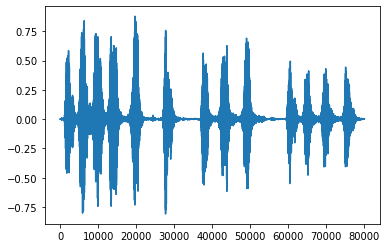

In [77]:
# ทำการทดสอบเพิ่มเติม

test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values : {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [78]:
# เรียกใช้แบบจำลอง และตรวจสอบผลลัพธ์

scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is : {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is : {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is : Animal (0.9834235906600952)
[Your model] The main sound is : dog (0.999647855758667)
